In [11]:
from ipywidgets import interact, IntSlider
import sys
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
matplotlib.rcParams['font.size'] = 14

# IP example: Gradient array with single source

## Purpose

- Explore the basic setup and physics of an induced polarization (IP)  survey within the context of kimberlite exploration. 

- Understand how the conductivity model, derived from the DC inversion, is used to solve the linearized IP problem. 

- Forward model and invert IP data using the SimPEG-Static package.

## Setup

### Linearization of induced polarization (IP) responses

$$ d^{IP} = F[\sigma(1-\eta)] - F[\sigma] $$
$$\simeq -\frac{\partial F[\sigma]}{\partial log(\sigma)} $$


- $F[\cdot]$: Static Maxwell's operator (taking $\sigma(x, y, z)$)

- $\eta$: Chargeability (ms or mV/V)

<img src="../images/DCIP_kimberlites.png" width=500> </img>

## Forward problem
### Setup mesh, load model, design survey, and forward model data

In [3]:
from SimPEG import Mesh, Utils, Maps, Survey
import numpy as np
from SimPEG.EM.Static import DC, IP, Utils as StaticUtils
from pymatsolver import PardisoSolver
import pickle


########################
# General Problem Setup
########################

# Setup tensor mesh

# Core cell sizes in x, y, and z
csx, csy, csz = 25., 25., 25.
# Number of core cells in each direction
ncx, ncy, ncz = 48, 48, 20
# Number of padding cells to add in each direction
npad = 7
# Vectors of cell lengthts in each direction
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
# Create mesh
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
# Map mesh coordinates from local to UTM coordiantes
xc = 300+5.57e5
yc = 600+7.133e6
zc = 425.
mesh._x0 = mesh.x0 + np.r_[xc, yc, zc]

# Load synthetic conductivity model matching the designated mesh
sigma = mesh.readModelUBC("VTKout_DC.dat")
# Identify air cells in the model
airind = sigma == 1e-8

# Obtain topographic surface from 3D conductivity model
mesh2D, topoCC = StaticUtils.gettopoCC(mesh, airind)


# Setup gradient array survey

# Define the source electrode locations
# Here we use a single dipole source (A-B electrode) in the x-direction)
Aloc1_x = np.r_[-600., 0, 0.] + np.r_[xc, yc, zc]
Bloc1_x = np.r_[600., 0, 0.] + np.r_[xc, yc, zc]

# Rx locations (M-N electrodes, x-direction)
# Find x and y cell centres in the interior portion of the mesh
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-300.+ xc, mesh.vectorCCx<300.+ xc)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-300.+ yc, mesh.vectorCCy<300.+ yc)]
# Grid selected cell centres to get M and N Rx electrode locations
Mx = Utils.ndgrid(x[:-1], y, np.r_[-12.5/2.])
Nx = Utils.ndgrid(x[1:], y, np.r_[-12.5/2.])
# Get cell ind for electrode locations to extract electrode elevation from topoCC
inds_Mx = Utils.closestPoints(mesh2D, Mx[:,:2])
inds_Nx = Utils.closestPoints(mesh2D, Nx[:,:2])
# Draped M and N electrode x,y,z locations
Mx_dr = np.c_[Mx[:,0], Mx[:,1], topoCC[inds_Mx]]
Nx_dr = np.c_[Nx[:,0], Nx[:,1], topoCC[inds_Nx]]

# Create Src and Rx classes for DC problem
rx_x = DC.Rx.Dipole(Mx_dr, Nx_dr)
src1 = DC.Src.Dipole([rx_x], Aloc1_x, Bloc1_x)


########################
# IP Problem
########################


# Load synthetic chargeability model matching the designated mesh
eta = mesh.readModelUBC("VTKout_eta.dat")

# Generate true IP data using true conductivity model
actmapIP = Maps.InjectActiveCells(mesh, ~airind, 0.)
problemIP = IP.Problem3D_CC(mesh, rho=1./sigma, etaMap=actmapIP)
problemIP.Solver = PardisoSolver
surveyIP = IP.Survey([src1])
problemIP.pair(surveyIP)
dataIP = surveyIP.dpred(eta[~airind])

### Visualize Conductivity and Chargeability Models

In [12]:
def compareTrueModels(indz,indy):
    fig = plt.figure(figsize=(11, 8))
    sig_min, sig_max = -4, -1
    eta_min, eta_max = 0, 1.6
    xmin, xmax = -500+xc, 500+xc
    ymin, ymax = -500+yc, 500+yc
    zmin, zmax = -500+zc, 0+zc
#     indz = 28
#     indy = 31
    # Axis label
    x = np.linspace(xmin+200, xmax-200,3)
    matplotlib.rcParams['font.size'] = 10

    # True Conductivity Model z-section
    ax1 = plt.subplot(1,1,1)
    pos =  ax1.get_position()
    ax1.set_position([pos.x0-0.1, pos.y0+0.3,  pos.width*0.5, pos.height*0.5])
    ax1,dat1 = viz(mesh, sigma, indz, airind, normal="Z", xc=xc,yc=yc,zc=zc, ax=ax1, cb=False, clim=(sig_min, sig_max))
    plt.gca().set_aspect('equal')
    ax1.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
    ax1.xaxis.set_visible(False)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)    
    ax1.set_ylabel('Northing (m)')

    # True Conductivity Model y-section
    pos =  ax1.get_position()
    ax2 = fig.add_axes([pos.x0+0.0525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
    ax2, dat2 = viz(mesh, sigma, indy, airind, normal="Y", xc=xc,yc=yc,zc=zc, ax=ax2, cb=False, clim=(sig_min, sig_max))
    plt.gca().set_aspect('equal')
    ax2.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(zmin, zmax) 
    ax2.set_xticks(map(int, x))
    ax2.set_xticklabels(map(str, map(int, x)),size=12)
    ax2.set_xlabel('Easting (m)')
    ax2.set_ylabel('Elev. (m)')

    # True Chargeability Model z-section
    ax3 = fig.add_axes([pos.x0+0.3, pos.y0,  pos.width, pos.height])
    ax3,dat3 = ax = viz(mesh, eta*1e3, indz, airind, normal="Z", xc=xc,yc=yc,zc=zc, ax=ax3, cb=False, clim=(eta_min, eta_max), scale="linear")
    plt.gca().set_aspect('equal')
    ax3.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    ax3.set_xlim(xmin, xmax)
    ax3.set_ylim(ymin, ymax)

    # True Chargeability Model y-section
    ax4 = fig.add_axes([pos.x0+0.3525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
    ax4, dat4 = viz(mesh, eta*1e3, indy, airind,  normal="Y", xc=xc,yc=yc,zc=zc, ax=ax4, cb=False, clim=(eta_min, eta_max), scale="linear")
    plt.gca().set_aspect('equal')
    ax4.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
    ax4.yaxis.set_visible(False)
    ax4.set_xlim(xmin, xmax)
    ax4.set_ylim(zmin, zmax) 
    ax4.set_xticks(map(int, x))
    ax4.set_xticklabels(map(str, map(int, x)),size=12)
    ax4.set_xlabel('Easting (m)')

    pos =  ax2.get_position()
    cbarax1 = fig.add_axes([pos.x0+0.02 , pos.y0-0.01 ,  pos.width-0.05, pos.height*0.05])  ## the parameters are the specified position you set
    cb1 = fig.colorbar(dat2[0],cax=cbarax1, orientation="horizontal", ax = cbarax1, ticks=np.linspace(sig_min,sig_max, 4), format="1.e%.f")
    cb1.set_label("Conductivity (S/m)",size=12)
    
    pos =  ax4.get_position()
    cbarax2 = fig.add_axes([pos.x0+0.02 , pos.y0-0.01 ,  pos.width-0.05, pos.height*0.05])  ## the parameters are the specified position you set
    cb2 = fig.colorbar(dat4[0],cax=cbarax2, orientation="horizontal", ax = cbarax2, ticks=np.linspace(eta_min,eta_max, 4), format="1.e%.f")
    cb2.set_label("Chargeability (ms)",size=12)

In [13]:
def viz(mesh, sigma, ind, airind, normal="Z", ax=None, label="Conductivity (S/m)", scale="log", clim=(-4, -1), xc=0, yc=0,zc=0., cb=True):
    if normal == "Z":
        if ax is None:
            fig = plt.figure(figsize=(5*1.2, 5))
            ax = plt.subplot(111)
    else:
        if ax is None:
            fig = plt.figure(figsize=(5*1.2, 2.5))
            ax = plt.subplot(111)

    temp = sigma.copy()

    if scale == "log":
        temp = np.log10(temp)

    temp[airind] = np.nan

    dat = mesh.plotSlice(temp, ind=ind, clim=clim, normal=normal, grid=False, pcolorOpts={"cmap":"viridis"}, ax=ax)
    if normal == "Z":
        ax.set_xlabel("Easting (m)")
        ax.set_ylabel("Northing (m)")
        xmin, xmax = -500+xc, 500+xc
        ymin, ymax = -500+yc, 500.+yc
        ax.set_title(("Elevation at %.1f m")%(mesh.vectorCCz[ind]))
    elif normal == "Y":
        ax.set_xlabel("Easting (m)")
        ax.set_ylabel("Elevation (m)")
        xmin, xmax = -500+xc, 500+xc
        ymin, ymax = -500+zc, 0.+zc
        ax.set_title(("Northing at %.1f m")%(mesh.vectorCCy[ind]))

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xticks(np.linspace(xmin, xmax, 3))
    ax.set_yticks(np.linspace(ymin, ymax, 3))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    # plt.tight_layout()

    if scale == "log":
        cbformat = "$10^{%1.1f}$"
    elif scale == "linear":
        cbformat = "%.1e"

    if clim is None:
        vmin, vmax = dat[0].get_clim()
    else:
        vmin, vmax = clim[0], clim[1]

    if cb:
        cb = plt.colorbar(dat[0], format=cbformat, ticks=np.linspace(vmin, vmax, 3))
        cb.set_label(label)
    # plt.show()
    return ax, dat

<function __main__.<lambda>>

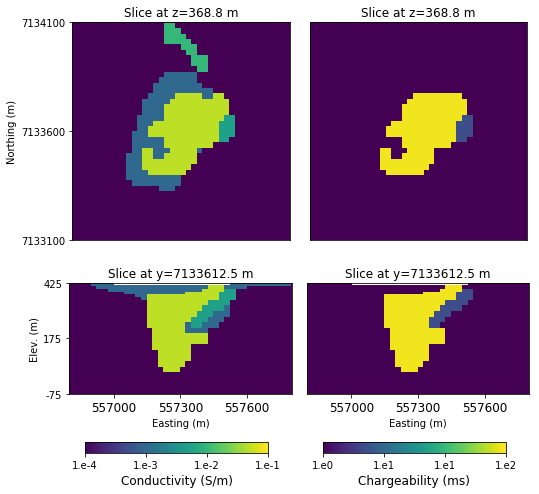

In [14]:
interact(lambda indz,indy: compareTrueModels(indz,indy), indz=IntSlider(min=0, max=mesh.nCz-1,step=1, value=28), indy=IntSlider(min=0, max=mesh.nCy-1,step=1, value=31))

### View electrode geometry for Gradient arrray
The survey geometry is shared with the DC problem. This simple survey is comprised of a single Tx electrode pair (A and B electrodes) with 552 associated Rx electrode pairs (M and N). 

- A and B electrode are separeted by 1200m in the E-W direction.
- M and N electrodes have 50m sepatation distances and are also oriented in the E-W direction.

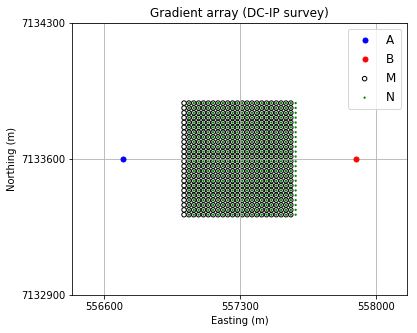

In [17]:
fig, ax = plt.subplots(1,1, figsize=(5*1.2,5))
plt.xlabel("Easting (m)"); plt.ylabel("Northing (m)")
ax.plot(Aloc1_x[0], Aloc1_x[1], 'bo', ms=5)
ax.plot(Bloc1_x[0], Bloc1_x[1], 'ro', ms=5)
ax.scatter(Mx[:,0], Mx[:,1],s=20, edgecolors="k", facecolors="none")
ax.scatter(Nx[:,0], Nx[:,1],s=5, edgecolors="none", facecolors="g")
ax.legend(("A", "B", "M", "N"), fontsize=12)
xmin, xmax = -700+xc, 700+xc
ymin, ymax = -700+yc, 700+yc
ax.set_xticks(np.linspace(xmin, xmax, 3))
ax.set_yticks(np.linspace(ymin, ymax, 3))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.axis('equal')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")  
ax.set_title("Gradient array (DC-IP survey)")
ax.grid(True)

## Plot IP data

In [18]:
def vizdata(data, src, rx, rxcomponent="X", clim=None, title=None, figsave=None, ax=None, cb=True,cbOrient="vertical"):
    if ax is None:
        fig = plt.figure(figsize=(6.8, 5.5))
        ax = plt.subplot(111)

    temp = data[src, rx]
    if rxcomponent=="X":
        X = Xx.copy()
        Y = Yx.copy()
    else:
        X = Xy.copy()
        Y = Yy.copy()
    temp = temp.reshape(X.shape, order="F")
    if clim is not None:
        vmin, vmax = clim[0], clim[1]
        dat = ax.contourf(X, Y, temp, 20, clim=clim, vmin=vmin, vmax=vmax, cmap="plasma")
        ax.contour(X, Y, temp, 10, colors="k")
    else:
        vmin, vmax = temp.min(), temp.max()
        dat = ax.contourf(X, Y, temp, 20, cmap="plasma")
        ax.contour(X, Y, temp, 10, colors="k")
        
    if title is not None:
        ax.set_title(title)
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()            
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xticks(np.linspace(xmin, xmax, 3))
    ax.set_yticks(np.linspace(ymin, ymax, 3))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)            
    
    if cb:
        cb = plt.colorbar(dat, orientation=cbOrient, ticks=np.linspace(vmin, vmax, 3), format="%.1e")
        cb.set_label("Potential (V)")
        
    if figsave is not None:
        fig.savefig(figsave, dpi=200)
    return ax

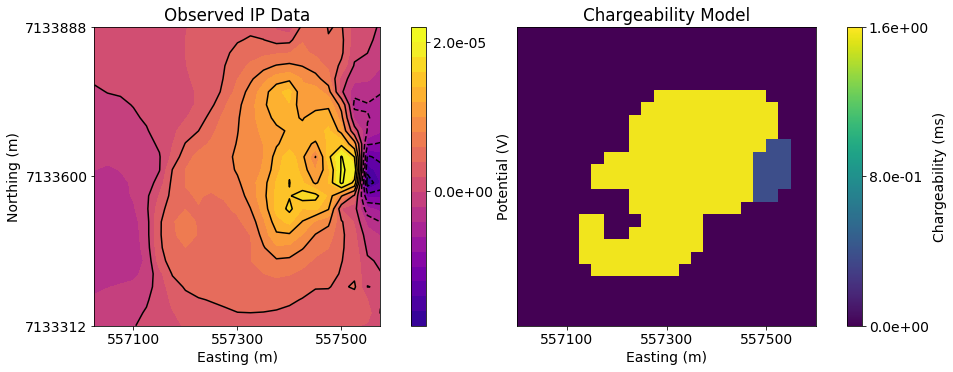

In [21]:
# Evaluate data at Rx locations
IPobsData = Survey.Data(surveyIP, v=dataIP)
Xx = 0.5*(Mx[:,0]+Nx[:,0]).reshape((23, 24), order="F")
Yx = Mx[:,1].reshape((23, 24), order="F")

fig = plt.figure(figsize=(11, 5.5))
xmin, xmax = -300+xc, 300+xc
ymin, ymax = -300+yc, 300+yc
indz = 28
matplotlib.rcParams['font.size'] = 14
# Axis label
x = np.linspace(xmin+100, xmax-100,3)

# IP observed data
ax1 = plt.subplot(1,1,1)
pos =  ax1.get_position()
ax1.set_position([pos.x0, pos.y0,  pos.width*0.5, pos.height])
ax1 = vizdata(IPobsData, src1, rx_x, ax=ax1, rxcomponent="X", title="Observed IP Data",clim=(-2e-5,2e-5))


# ax1.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
# ax1.xaxis.set_visible(False)
# ax1.set_xlim(xmin, xmax)
# ax1.set_ylim(ymin, ymax)   
plt.gca().set_aspect('equal')

ax1.set_xticks(map(int, x))
ax1.set_xticklabels(map(str, map(int, x)),size=14)
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')

# True Chargeability model
ax2 = fig.add_axes([pos.x0+0.55, pos.y0,  pos.width, pos.height])
ax2,dat2 = viz(mesh, eta*1e3, indz, airind, normal="Z", xc=xc, yc=yc, zc=zc, ax=ax2, label="Chargeability (ms)", scale="linear", clim=(0, 1.6))
plt.gca().set_aspect('equal')
ax2.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
ax2.yaxis.set_visible(False)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.set_xticks(map(int, x))
ax2.set_xticklabels(map(str, map(int, x)),size=14)
ax2.set_xlabel('Easting (m)')
ax2.set_title('Chargeability Model')

# pos =  ax2.get_position()
# # cbarax = fig.add_axes([pos.x0+0.02 , pos.y0-0.01 ,  pos.width*0.05, pos.height])  ## the parameters are the specified position you set
# cb2 = fig.colorbar(dat2[0], orientation="vertical", ax = ax2, ticks=np.linspace(-4, -3, 4), format="1.e%.f")
# cb2.set_label("Chargeability (ms)",size=12)